In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

## Configuration & Constants

In [2]:
# --- 1. Configuration & Constants ---
# File paths (assuming they are in the same directory as the script)
WHEAT_CHR1A_FILE = "NC_057794.1_Triticum_aestivum_chr1A.fasta"
BETALAIN_CDS_FILE = "CYP76AD1.fasta"
WHEAT_TARGET_LOCUS_FILE = "LOC732708.fasta" # For reference/verification if needed

In [4]:
# Target gene information for LOC732708 on wheat chromosome 1A
# NC_057794.1 (6674705..6677047, complement)
# NCBI coordinates are 1-based, inclusive. Python slicing is 0-based, exclusive for end.
LOC732708_START_NCBI = 6674705
LOC732708_END_NCBI = 6677047
LOC732708_IS_COMPLEMENT = True

In [5]:
# Convert to 0-based for Python slicing
LOC732708_START_PY = LOC732708_START_NCBI - 1
LOC732708_END_PY = LOC732708_END_NCBI # Slice goes up to, but doesn't include, end

## Helper Functions

In [6]:
def load_fasta_sequence(fasta_file):
    """
    Loads a single sequence from a FASTA file.
    Args:
        fasta_file (str): Path to the FASTA file.
    Returns:
        Bio.Seq.Seq: The sequence object.
    """
    try:
        record = SeqIO.read(fasta_file, "fasta")
        print(f"Successfully loaded: {record.id} from {fasta_file} (Length: {len(record.seq)})")
        return record.seq
    except Exception as e:
        print(f"Error loading {fasta_file}: {e}")
        raise

In [7]:
def find_gRNA_target_site(chromosome_seq, target_gene_start_py, target_gene_end_py,
                          gRNA_len=20, pam_motif="GG"):
    """
    Finds a potential gRNA target site (protospacer + PAM) within the target gene region.
    This is a simplified search. A real gRNA design tool would be more sophisticated.
    It looks for a PAM (e.g., NGG, so "GG" preceded by any N) and takes the preceding 20bp.
    Args:
        chromosome_seq (Bio.Seq.Seq): The full chromosome sequence.
        target_gene_start_py (int): 0-based start coordinate of the target gene on chromosome.
        target_gene_end_py (int): 0-based end coordinate of the target gene on chromosome.
        gRNA_len (int): Length of the gRNA seed sequence (protospacer).
        pam_motif (str): The core PAM sequence to search for (e.g., "GG" for NGG PAM).
    Returns:
        tuple: (protospacer_seq, pam_seq, cut_site_abs) or (None, None, None) if not found.
               cut_site_abs is the 0-based coordinate on the full chromosome.
    """
    target_region_on_chr = chromosome_seq[target_gene_start_py:target_gene_end_py]
    
    # Search for PAM on the forward strand of this region
    # SpCas9 PAM is typically NGG (N is any base)
    # We'll search for the "GG" part and ensure there's a preceding base.
    # The protospacer is *before* the PAM.
    
    # Iterate to find PAM: We need 20bp (protospacer) + 1bp (N) + 2bp (GG)
    # So, search for "GG" starting from index gRNA_len, up to len(target_region_on_chr) - 2
    for i in range(gRNA_len, len(target_region_on_chr) - 2):
        # Check for PAM: target_region_on_chr[i+1:i+3] would be GG
        # And target_region_on_chr[i] would be N
        if target_region_on_chr[i+1:i+3].upper() == pam_motif.upper():
            pam_seq_found = target_region_on_chr[i:i+3] # NGG
            protospacer_seq_found = target_region_on_chr[i-gRNA_len:i]
            
            # CRISPR-Cas9 typically cuts ~3-4 bp upstream of the PAM, within the protospacer
            # Let's say 3bp upstream from the PAM start (i.e., after 17th base of 20bp protospacer)
            cut_site_relative_to_protospacer_start = gRNA_len - 3 
            
            # Absolute cut site on the chromosome:
            # target_gene_start_py (start of gene)
            # + (i - gRNA_len) (start of protospacer within gene region)
            # + cut_site_relative_to_protospacer_start (cut pos within protospacer)
            cut_site_abs = target_gene_start_py + (i - gRNA_len) + cut_site_relative_to_protospacer_start
            
            print(f"Found potential gRNA target site in LOC732708 region:")
            print(f"  Protospacer (on chr): ...{protospacer_seq_found[-10:]}")
            print(f"  PAM (on chr):         {pam_seq_found}")
            print(f"  Relative cut site in protospacer: after base {cut_site_relative_to_protospacer_start}")
            print(f"  Absolute cut site on chromosome (0-based): {cut_site_abs}")
            return protospacer_seq_found, pam_seq_found, cut_site_abs
            
    print(f"Could not find a suitable {pam_motif}-based PAM site in the search window of LOC732708.")
    return None, None, None

In [8]:

def plot_genome_modification(chr_len, gene_details, insertion_detail, plot_window_bp=5000):
    """
    Plots a simplified representation of the genome modification.
    Args:
        chr_len (int): Total length of the chromosome (or segment being plotted).
        gene_details (dict): Info about genes to plot. Example:
            { "LOC732708_original": {"start": s, "end": e, "strand": "+", "color": "blue"},
              "CYP76AD1_inserted": {"start": s, "end": e, "strand": "+", "color": "red"} }
        insertion_detail (dict): Info about insertion. Example:
            { "cut_site": cs, "inserted_gene_name": "CYP76AD1_inserted",
              "original_gene_name": "LOC732708_original" }
        plot_window_bp (int): Number of base pairs to show around the modification site.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=False, sharey=True)
    fig.suptitle("Simulated CRISPR Modification: Wheatgrass Chr1A", fontsize=16)

    cut_site = insertion_detail["cut_site"]
    inserted_gene_name = insertion_detail["inserted_gene_name"]
    original_target_gene_name = insertion_detail["original_gene_name"]
    
    # Determine plot range centered around the cut site
    plot_start = max(0, cut_site - plot_window_bp // 2)
    plot_end = min(chr_len, cut_site + plot_window_bp // 2)
    
    # --- Plot 1: Before Modification ---
    ax1.set_title("Before CRISPR Modification")
    ax1.set_xlim(plot_start, plot_end)
    ax1.set_ylim(0, 3)
    ax1.axhline(1.5, color='gray', linestyle='-', linewidth=2, label="Chromosome 1A")

    # Plot original target gene
    orig_gene = gene_details[original_target_gene_name]
    gene_patch_orig = patches.Rectangle(
        (orig_gene["start"], 1.25), orig_gene["end"] - orig_gene["start"], 0.5,
        facecolor=orig_gene["color"], edgecolor='black', label=original_target_gene_name
    )
    ax1.add_patch(gene_patch_orig)
    ax1.text(orig_gene["start"] + (orig_gene["end"] - orig_gene["start"]) / 2, 0.8,
             f"{original_target_gene_name}\n({orig_gene['strand']})", ha='center', va='center', fontsize=8)

    # Mark gRNA cut site
    ax1.axvline(cut_site, color='orange', linestyle='--', linewidth=2, label=f"Target Cut Site ({cut_site+1})")
    ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax1.set_xlabel("Chromosome Position (bp)")
    ax1.legend(loc="upper right")

    # --- Plot 2: After Modification ---
    ax2.set_title("After CRISPR Modification (CYP76AD1 Inserted)")
    ax2.set_xlim(plot_start, plot_end) # Keep same x-axis range for comparison if not re-centering
    ax2.set_ylim(0, 3)
    ax2.axhline(1.5, color='gray', linestyle='-', linewidth=2, label="Chromosome 1A (modified)")

    # Plot original gene (potentially disrupted or now flanking the insert)
    # For simplicity, we assume insertion *at* the cut site, splitting the original if cut is inside.
    # If cut_site is within original_gene:
    if orig_gene["start"] < cut_site < orig_gene["end"]:
        # Part 1 of original gene
        gene_patch_orig1 = patches.Rectangle(
            (orig_gene["start"], 1.25), cut_site - orig_gene["start"], 0.5,
            facecolor=orig_gene["color"], edgecolor='black', alpha=0.7
        )
        ax2.add_patch(gene_patch_orig1)
        # Part 2 of original gene (shifted by inserted gene length)
        inserted_gene_len = gene_details[inserted_gene_name]["end"] - gene_details[inserted_gene_name]["start"]
        gene_patch_orig2 = patches.Rectangle(
            (cut_site + inserted_gene_len, 1.25), 
            orig_gene["end"] - cut_site, 0.5, # original length of part 2
            facecolor=orig_gene["color"], edgecolor='black', alpha=0.7
        )
        ax2.add_patch(gene_patch_orig2)
        ax2.text(orig_gene["start"] + (cut_site - orig_gene["start"]) / 2, 0.8,
             f"{original_target_gene_name} (5' part)\n({orig_gene['strand']})", ha='center', va='center', fontsize=8)
        ax2.text((cut_site + inserted_gene_len) + (orig_gene["end"] - cut_site) / 2, 0.8,
             f"{original_target_gene_name} (3' part)\n({orig_gene['strand']})", ha='center', va='center', fontsize=8)
    else: # Cut site is outside the original gene, just show original gene as is
        gene_patch_orig_shifted = patches.Rectangle(
            (orig_gene["start"], 1.25), orig_gene["end"] - orig_gene["start"], 0.5,
            facecolor=orig_gene["color"], edgecolor='black', label=original_target_gene_name, alpha=0.7
        ) # This needs adjustment if things shift
        # This part of plotting is tricky if insertion is not within the plotted gene.
        # For now, let's assume the original gene plotted is the one being disrupted.
        ax2.add_patch(gene_patch_orig_shifted)
        ax2.text(orig_gene["start"] + (orig_gene["end"] - orig_gene["start"]) / 2, 0.8,
             f"{original_target_gene_name}\n({orig_gene['strand']})", ha='center', va='center', fontsize=8)


    # Plot inserted gene
    ins_gene = gene_details[inserted_gene_name]
    gene_patch_ins = patches.Rectangle(
        (ins_gene["start"], 1.25), ins_gene["end"] - ins_gene["start"], 0.5,
        facecolor=ins_gene["color"], edgecolor='black', label=inserted_gene_name
    )
    ax2.add_patch(gene_patch_ins)
    ax2.text(ins_gene["start"] + (ins_gene["end"] - ins_gene["start"]) / 2, 0.8,
             f"{inserted_gene_name}\n({ins_gene['strand']})", ha='center', va='center', fontsize=8)

    ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax2.set_xlabel("Chromosome Position (bp) - Note: Coordinates shift after insertion point")
    ax2.legend(loc="upper right")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()

## Main Simulation Logic

In [9]:

def run_crispr_simulation():
    print("--- Starting CRISPR Modification Simulation ---")

    # Load sequences
    print("\n--- Loading Sequences ---")
    wheat_chr1A_seq = load_fasta_sequence(WHEAT_CHR1A_FILE)
    betalain_cds_seq = load_fasta_sequence(BETALAIN_CDS_FILE)
    # loc732708_ref_seq = load_fasta_sequence(WHEAT_TARGET_LOCUS_FILE) # For verification

    # Verify LOC732708 sequence from chromosome
    print("\n--- Verifying Target Locus (LOC732708) ---")
    loc732708_on_chr = wheat_chr1A_seq[LOC732708_START_PY:LOC732708_END_PY]
    if LOC732708_IS_COMPLEMENT:
        loc732708_on_chr_sense = loc732708_on_chr.reverse_complement()
        print(f"LOC732708 is on the complement strand. Its 'sense' sequence (length {len(loc732708_on_chr_sense)} bp) will be used for comparison if needed.")
    else:
        loc732708_on_chr_sense = loc732708_on_chr
        print(f"LOC732708 is on the forward strand. Length {len(loc732708_on_chr_sense)} bp.")
    
    # print(f"Extracted LOC732708 from Chr1A (first 30bp): {loc732708_on_chr_sense[:30]}...")
    # print(f"Reference LOC732708 from FASTA (first 30bp): {loc732708_ref_seq[:30]}...")
    # if loc732708_ref_seq == loc732708_on_chr_sense:
    #     print("SUCCESS: Extracted LOC732708 matches reference FASTA.")
    # else:
    #     print("WARNING: Extracted LOC732708 does NOT match reference FASTA. Check coordinates/strand.")


    # Find gRNA target site and cut site
    # We'll target LOC732708 for disruption/insertion.
    # The gRNA will target one of the strands of the DNA at this locus.
    # The find_gRNA_target_site function looks at the sequence *as it is on the chromosome*.
    print("\n--- Designing gRNA and Finding Cut Site ---")
    protospacer, pam, cut_site_abs = find_gRNA_target_site(
        wheat_chr1A_seq,
        LOC732708_START_PY,
        LOC732708_END_PY
    )

    if cut_site_abs is None:
        print("CRISPR simulation cannot proceed without a valid cut site. Exiting.")
        # As a fallback, if no site is found in the specific LOC732708 window,
        # you could pick an arbitrary cut site *within* LOC732708 for demonstration.
        # For this example, we'll require a found site.
        # Example fallback: cut_site_abs = LOC732708_START_PY + len(loc732708_on_chr) // 2
        # print(f"Using a fallback arbitrary cut site within LOC732708: {cut_site_abs}")
        return

    # Simulate CRISPR cut and insertion of Betalain gene
    # We assume Homology Directed Repair (HDR) for precise insertion of the betalain gene.
    print("\n--- Simulating Genome Editing ---")
    print(f"Original Chromosome 1A length: {len(wheat_chr1A_seq)} bp")
    
    # The sequence of the betalain gene to be inserted.
    # For simplicity, we insert it in the forward orientation relative to the chromosome's forward strand.
    # A real scenario would require adding promoter/terminator sequences for the betalain gene.
    gene_to_insert = betalain_cds_seq
    print(f"Betalain gene (CYP76AD1 CDS) length: {len(gene_to_insert)} bp")

    # Perform the "cut and paste"
    chr_segment_before_cut = wheat_chr1A_seq[:cut_site_abs]
    chr_segment_after_cut = wheat_chr1A_seq[cut_site_abs:]

    modified_wheat_chr1A_seq = chr_segment_before_cut + gene_to_insert + chr_segment_after_cut
    print(f"Modified Chromosome 1A length: {len(modified_wheat_chr1A_seq)} bp")

    print(f"\nOriginal sequence around cut site ({cut_site_abs-10} to {cut_site_abs+10}):")
    print(f"...{wheat_chr1A_seq[cut_site_abs-10 : cut_site_abs]}<--CUT-->{wheat_chr1A_seq[cut_site_abs : cut_site_abs+10]}...")

    print(f"\nModified sequence around insertion site:")
    print(f"...{modified_wheat_chr1A_seq[cut_site_abs-10 : cut_site_abs]}<--INSERTED-->{modified_wheat_chr1A_seq[cut_site_abs : cut_site_abs + len(gene_to_insert)]}...")
    print(f"   (Showing first 10bp of insert: {gene_to_insert[:10]})")


    # --- 4. Plotting ---
    print("\n--- Generating Plot ---")
    
    # Define gene details for plotting
    # Note: coordinates for LOC732708 in the "after" plot would be tricky if it's split.
    # The plot function handles this by showing parts of the original gene if split.
    
    # Coordinates of inserted betalain gene
    inserted_betalain_start_py = cut_site_abs
    inserted_betalain_end_py = cut_site_abs + len(gene_to_insert)

    gene_plot_details = {
        "LOC732708_original": {
            "start": LOC732708_START_PY,
            "end": LOC732708_END_PY,
            "strand": "-" if LOC732708_IS_COMPLEMENT else "+", # Representing its actual orientation
            "color": "skyblue"
        },
        "CYP76AD1_inserted": {
            "start": inserted_betalain_start_py,
            "end": inserted_betalain_end_py,
            "strand": "+", # Assuming we insert it to be read on forward strand
            "color": "salmon"
        }
    }
    
    insertion_plot_detail = {
        "cut_site": cut_site_abs, # This is the point of insertion
        "inserted_gene_name": "CYP76AD1_inserted",
        "original_gene_name": "LOC732708_original"
    }

    plot_genome_modification(
        chr_len=len(wheat_chr1A_seq), # Original length for context of "before"
        gene_details=gene_plot_details,
        insertion_detail=insertion_plot_detail,
        plot_window_bp= (LOC732708_END_PY - LOC732708_START_PY) + len(gene_to_insert) + 2000 # show target + insert + some flanking
    )
    
    print("\n--- Simulation Complete ---")

--- Starting CRISPR Modification Simulation ---

--- Loading Sequences ---
Successfully loaded: NC_057794.1 from NC_057794.1_Triticum_aestivum_chr1A.fasta (Length: 598660471)
Successfully loaded: AQS22859.1 from CYP76AD1.fasta (Length: 497)

--- Verifying Target Locus (LOC732708) ---
LOC732708 is on the complement strand. Its 'sense' sequence (length 2343 bp) will be used for comparison if needed.

--- Designing gRNA and Finding Cut Site ---
Found potential gRNA target site in LOC732708 region:
  Protospacer (on chr): ...GCTGCTTTGC
  PAM (on chr):         TGG
  Relative cut site in protospacer: after base 17
  Absolute cut site on chromosome (0-based): 6674739

--- Simulating Genome Editing ---
Original Chromosome 1A length: 598660471 bp
Betalain gene (CYP76AD1 CDS) length: 497 bp
Modified Chromosome 1A length: 598660968 bp

Original sequence around cut site (6674729 to 6674749):
...GCTGCTGCTT<--CUT-->TGCTGGTTAT...

Modified sequence around insertion site:
...GCTGCTGCTT<--INSERTED-->MD

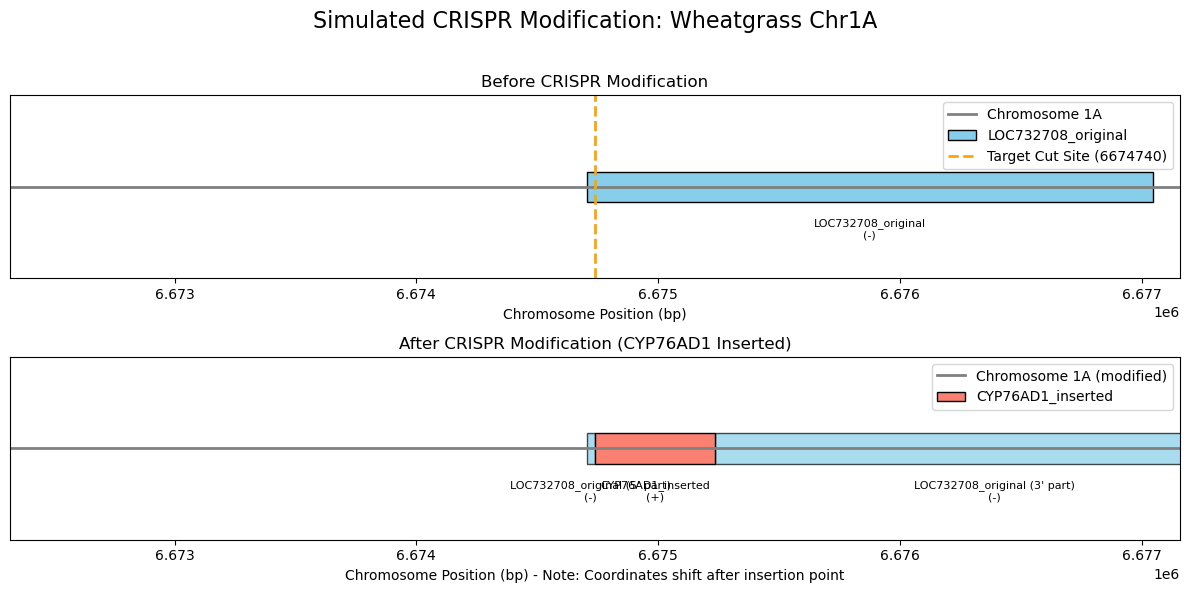


--- Simulation Complete ---


In [10]:
run_crispr_simulation()